# Прогноз объема продаж методом Тройного экспоненциального сглаживания Хольта-Винтерса.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing

pd.options.display.float_format = '{:,.4f}'.format

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
df = pd.read_csv('Data for Forecast.csv', decimal=",")
df.head()

,year,month,Sales
0,2009,1,"44,265,939.1300"
1,2009,3,"54,900,710.1100"
2,2009,2,"55,917,784.5800"
3,2009,4,"59,119,663.8800"
4,2009,5,"60,949,016.3100"


Немного подправим данные для более удобного отображения

In [3]:
df['Date'] = pd.period_range(start='2009-01', end='2019-11', freq='M')
df.index = df['Date']
df = df.drop(['year', 'month', 'Date'], axis=1)
df.head()

,Sales
Date,
2009-01,"44,265,939.1300"
2009-02,"54,900,710.1100"
2009-03,"55,917,784.5800"
2009-04,"59,119,663.8800"
2009-05,"60,949,016.3100"


In [4]:
df.describe()

,Sales
count,131.0000
mean,"187,764,744.3836"
std,"81,148,433.0577"
min,"44,265,939.1300"
25%,"136,705,527.6000"
50%,"174,634,064.6000"
75%,"234,088,548.5500"
max,"474,374,633.1000"


### Визуализируем данные.
На графике ниже отчетливо видно, что объем продаж колеблется с повторяющимся периодом.

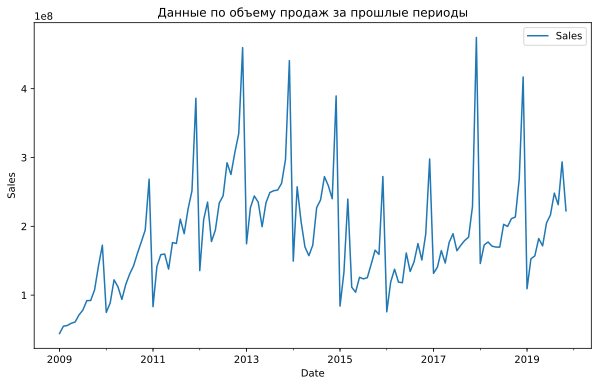

In [5]:
ax = df.plot(figsize=(10, 6))
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.title('Данные по объему продаж за прошлые периоды')
plt.show()

### Построение прогноза и выбор лучшей модели прогнозирования.
Для посторения прогноза будем использовать Тройное экспоненциальное сглаживание по методу Хольта-Винтерса. Для этого возьмем функцию ExponentialSmoothing из библиотеки statsmodels. Нам не придется тратить время на написание функции, мы только подберем наиболее подходящие параметры.

На графике представленном ниже показаны существующие данные, данные рассчитанные с помощью функции с разными параметрами и прогноз на 13 месяцев вперед ( с декабря 2019 до декабря 2020).

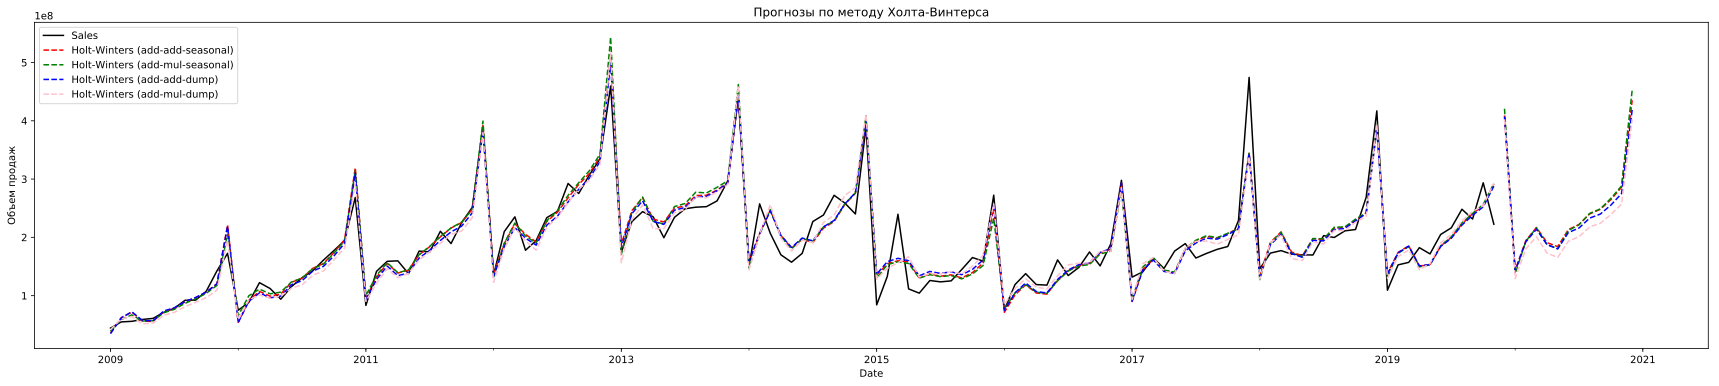

In [6]:
# Аддитивный тренд, Аддитивный сезон season_length=12 и использование преобразования Бокса-Кокса
fit1 = ExponentialSmoothing(df.Sales, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)

# Аддитивный тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса
fit2 = ExponentialSmoothing(df.Sales, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)

# Аддитивный демпфированный тренд, аддитивный сезонный период season_length=12 и использование преобразования Бокса-Кокса
fit3 = ExponentialSmoothing(df.Sales, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)

# Аддитивный затухающий тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса.
fit4 = ExponentialSmoothing(df.Sales, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = df.plot(figsize=(30,6), color='black', title="Прогнозы по методу Холта-Винтерса" )
ax.set_ylabel("Объем продаж")
ax.set_xlabel("Date")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')
fit3.fittedvalues.plot(ax=ax, style='--', color='blue')
fit4.fittedvalues.plot(ax=ax, style='--', color='pink')

fit1.forecast(13).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', color='red', legend=True)
fit2.forecast(13).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', color='green', legend=True)
fit3.forecast(13).rename('Holt-Winters (add-add-dump)').plot(ax=ax, style='--', color='blue', legend=True)
fit4.forecast(13).rename('Holt-Winters (add-mul-dump)').plot(ax=ax, style='--', color='pink', legend=True)
plt.show()

### Таблица параметров
Данная таблица позволит сравнить результаты и параметризацию. Где

$\alpha$ - коэффициент сглаживания ряда

$\beta$ - коэффициент сглаживания тренда

$\gamma$ - коэффициент сглаживания сезонности

$l_0$ - начальный уровень

$b_0$ - начальный тренд

$SSE$ - сумма квадратов ошибок

In [7]:
results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.3405,0.3342,0.3204,0.4878
$\beta$,0.1078,0.1054,0.0903,0.3133
$\gamma$,0.0000,0.0000,0.0000,0.0000
$l_0$,824.2311,869.8103,815.4535,869.8107
$b_0$,8.6614,11.0325,12.2238,0.0008
SSE,"84,248,287,552,868,656.0000","87,581,522,308,749,936.0000","80,769,322,850,063,360.0000","83,982,035,912,699,952.0000"


### Результаты расчета

Посмотрим более наглядно исходные значения $y_t$, уровень $l_t$, тренд $b_t$, сезон $s_t$ и подогнанные значения $\hat{y}_t$ для этих моделей.

##### 1.Аддитивный тренд, Аддитивный сезон season_length=12 и использование преобразования Бокса-Кокса

In [8]:
df1 = pd.DataFrame(np.c_[df.Sales, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=df.index)
df1.append(fit1.forecast(8).rename(r'$\hat{y}_t$').to_frame(), sort=True)
df1.head()

,$y_t$,$l_t$,$b_t$,$s_t$,$\hat{y}_t$
Date,,,,,
2009-01,"44,265,939.1300","96,050,805.7200","-96,049,972.8275","-55,019,266.9668","35,832,561.6920"
2009-02,"54,900,710.1100","96,385,169.8549","-96,384,312.6100","-37,792,998.4855","62,123,755.9563"
2009-03,"55,917,784.5800","92,658,031.5715","-92,657,174.4366","-28,088,877.3263","71,785,555.3081"
2009-04,"59,119,663.8800","96,678,029.7305","-96,677,184.7451","-39,039,510.0658","56,238,546.1895"
2009-05,"60,949,016.3100","102,154,680.4446","-102,153,824.2031","-43,837,077.6489","55,694,253.6047"


##### 2. Аддитивный тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса

In [9]:
df2 = pd.DataFrame(np.c_[df.Sales, fit2.level, fit2.slope, fit2.season, fit2.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=df.index)
df2.append(fit2.forecast(8).rename(r'$\hat{y}_t$').to_frame(), sort=True)
df2.head()

,$y_t$,$l_t$,$b_t$,$s_t$,$\hat{y}_t$
Date,,,,,
2009-01,"44,265,939.1300","114,297,548.4476","-114,296,667.6048",0.3549,"38,783,784.1506"
2009-02,"54,900,710.1100","116,753,562.7721","-116,752,657.5796",0.4934,"58,998,872.6920"
2009-03,"55,917,784.5800","114,822,798.0060","-114,821,887.7324",0.5495,"66,933,274.3924"
2009-04,"59,119,663.8800","120,968,012.9481","-120,967,108.9038",0.4738,"56,414,635.1321"
2009-05,"60,949,016.3100","128,502,306.0669","-128,501,387.3331",0.4533,"56,933,904.7709"


##### 3. Аддитивный демпфированный тренд, аддитивный сезонный период season_length=12 и использование преобразования Бокса-Кокса

In [10]:
df3 = pd.DataFrame(np.c_[df.Sales, fit3.level, fit3.slope, fit3.season, fit3.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=df.index)
df3.append(fit3.forecast(8).rename(r'$\hat{y}_t$').to_frame(), sort=True)
df3.head()

,$y_t$,$l_t$,$b_t$,$s_t$,$\hat{y}_t$
Date,,,,,
2009-01,"44,265,939.1300","94,446,324.8803","-94,445,497.2030","-54,164,434.5298","34,823,643.4058"
2009-02,"54,900,710.1100","96,247,616.5607","-96,246,760.8712","-37,746,299.5057","61,573,412.6325"
2009-03,"55,917,784.5800","93,665,321.3746","-93,664,462.1519","-28,442,525.5387","72,237,077.2193"
2009-04,"59,119,663.8800","98,003,100.7928","-98,002,250.6725","-39,825,496.6358","57,376,775.3152"
2009-05,"60,949,016.3100","103,499,461.3904","-103,498,599.9228","-44,730,450.1109","56,819,944.6340"


##### 4. Аддитивный затухающий тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса.

In [11]:
df4 = pd.DataFrame(np.c_[df.Sales, fit4.level, fit4.slope, fit4.season, fit4.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=df.index)
df4.append(fit4.forecast(8).rename(r'$\hat{y}_t$').to_frame(), sort=True)
df4.head()

,$y_t$,$l_t$,$b_t$,$s_t$,$\hat{y}_t$
Date,,,,,
2009-01,"44,265,939.1300","107,887,591.4316","-107,886,721.6202",0.3982,"41,748,954.6795"
2009-02,"54,900,710.1100","103,364,959.3140","-103,364,081.9004",0.5559,"59,970,446.9831"
2009-03,"55,917,784.5800","96,744,282.6562","-96,743,416.5536",0.6204,"64,132,161.8774"
2009-04,"59,119,663.8800","103,435,601.9576","-103,434,753.0534",0.5336,"51,624,508.6513"
2009-05,"60,949,016.3100","110,973,135.1737","-110,972,268.8912",0.5110,"52,854,494.7699"


#### Теперь, посмотрим на уровни, тренды и сезонные компоненты моделей.

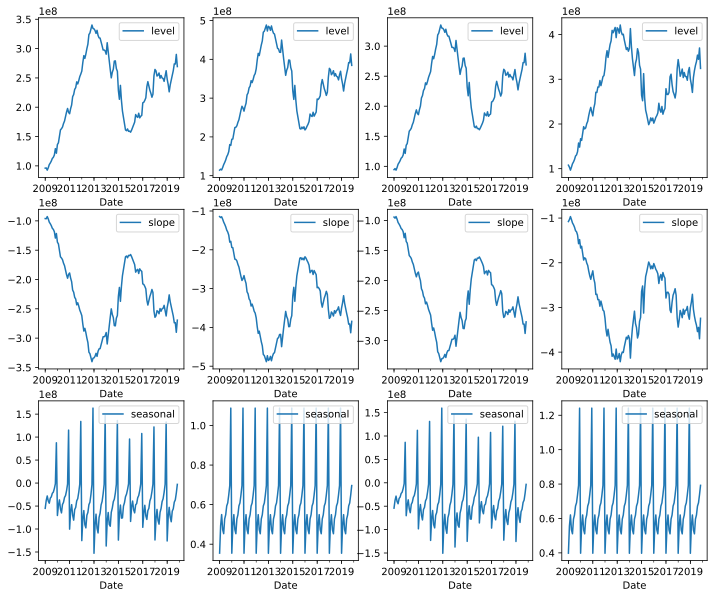

In [12]:
states1 = pd.DataFrame(np.c_[fit1.level, fit1.slope, fit1.season], columns=['level','slope','seasonal'], index=df.index)
states2 = pd.DataFrame(np.c_[fit2.level, fit2.slope, fit2.season], columns=['level','slope','seasonal'], index=df.index)
states3 = pd.DataFrame(np.c_[fit3.level, fit3.slope, fit3.season], columns=['level','slope','seasonal'], index=df.index)
states4 = pd.DataFrame(np.c_[fit4.level, fit4.slope, fit4.season], columns=['level','slope','seasonal'], index=df.index)

fig, [[ax1, ax4, ax7, ax10],[ax2, ax5, ax8, ax11], [ax3, ax6, ax9, ax12]] = plt.subplots(3, 4, figsize=(12,10))

states1[['level']].plot(ax=ax1)
states1[['slope']].plot(ax=ax2)
states1[['seasonal']].plot(ax=ax3)

states2[['level']].plot(ax=ax4)
states2[['slope']].plot(ax=ax5)
states2[['seasonal']].plot(ax=ax6)

states3[['level']].plot(ax=ax7)
states3[['slope']].plot(ax=ax8)
states3[['seasonal']].plot(ax=ax9)

states4[['level']].plot(ax=ax10)
states4[['slope']].plot(ax=ax11)
states4[['seasonal']].plot(ax=ax12)

plt.show()

### Оценка точности прогноза.

Cначала рассчитаем сумму квадратов $y_t$.

In [13]:
sum_y_t2 = sum(np.square(df['Sales']))
sum_y_t2

5.474542363983984e+18

Теперь рассчитаем точность для моделей fit3 и fit4.

In [14]:
accuracy = pd.DataFrame(columns=["Additive", 'Multiplicative', 'Additive Dam', 'Multiplica Dam'], index=['Model error', 'Accuracy'])
accuracy["Additive"] = [(fit1.sse / sum_y_t2), (1 - (fit1.sse / sum_y_t2))]
accuracy["Multiplicative"] = [(fit2.sse / sum_y_t2), (1 - (fit2.sse / sum_y_t2))]
accuracy["Additive Dam"] = [(fit3.sse / sum_y_t2), (1 - (fit3.sse / sum_y_t2))]
accuracy["Multiplica Dam"] = [(fit4.sse / sum_y_t2), (1 - (fit4.sse / sum_y_t2))]

##### Таблица отклонений ошибки модели от прогнозной модели и точность прогноза

In [15]:
accuracy

,Additive,Multiplicative,Additive Dam,Multiplica Dam
Model error,0.0154,0.0160,0.0148,0.0153
Accuracy,0.9846,0.9840,0.9852,0.9847


Исходя из полученной информации, я остановлю свой выбор на модели со следующими параметрами: аддитивный затухающий тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса. Точность данной модели составляет __98,52%__

In [16]:
fit3.params

{'smoothing_level': 0.32043325825606994,
 'smoothing_slope': 0.09026413773879514,
 'smoothing_seasonal': 0.0,
 'damping_slope': 0.9530635090954672,
 'initial_level': 815.4535133950769,
 'initial_slope': 12.223808107731974,
 'initial_seasons': array([-204.93560939, -115.43329585,  -82.24115999, -125.53932722,
        -139.0260926 ,  -94.13132789,  -83.0194197 ,  -58.86840666,
         -49.86919142,  -29.32974145,   -4.16204313,  153.38767998]),
 'use_boxcox': True,
 'lamda': 0.3018317814933313,
 'remove_bias': False}

#### Теперь запишем предсказанные значения в DataFrame и сохраним в csv.

In [17]:
df = df.append(fit3.forecast(13).rename('Sales').to_frame(), sort=True)

In [23]:
df.tail(14)

,Sales
2019-11,"222,495,636.7000"
2019-12,"407,004,590.8077"
2020-01,"142,458,338.6263"
2020-02,"192,247,972.7898"
2020-03,"213,901,858.4284"
2020-04,"187,497,062.8133"
2020-05,"180,163,934.1987"
2020-06,"208,199,831.6711"
2020-07,"216,038,714.6758"
2020-08,"232,987,769.5814"


In [20]:
df.to_csv('Sales forecast.csv', sep=';', index=True)

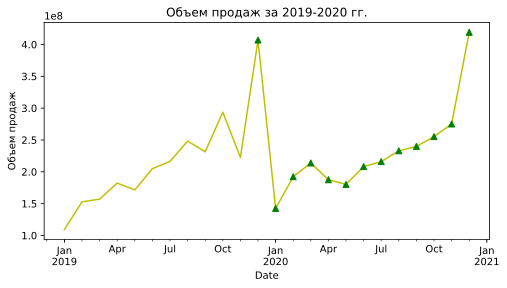

In [22]:
ax = df[120:145].plot(figsize=(8,4), color='y', title="Объем продаж за 2019-2020 гг.", legend=False)
ax.set_ylabel("Объем продаж")
ax.set_xlabel("Date")

df[131:148].plot(ax=ax, style='g^', legend=False)

plt.show()